In [6]:
%load_ext autoreload
%autoreload 2
import img_text_composition_models
from enum import Enum
import datasets
import torchvision
import torch
from main import load_dataset, create_model_and_optimizer
import test_retrieval
from tqdm import tqdm
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
class opt_config:
    def __init__(self):
        self.dataset = "css3d"
        self.dataset_path = "../data/CSSDataset/CSS-vn-vanilla-v2.json" 
        self.model = "tirg" 
        self.loss = "soft_triplet" 
        self.comment = "css3d_tirg"
        self.embed_dim = 512
        self.learning_rate = 1e-2
        self.weight_decay = 1e-6 
        self.f = ""
        self.learning_rate_decay_frequency = 99999999
        self.batch_size = 32
        self.num_epochs = 100
        self.n_epochs_valudations = 5
        self.loader_num_workers = 4
        self.pretrained_weights = "runs/Sep23_05-38-54_ai-servers-3css_vn_vanilla_v2/latest_checkpoint.pth"
        
opt = opt_config()

trainset, testset = load_dataset(opt)

model = img_text_composition_models.TIRG(texts, embed_dim=opt.embed_dim)

Reading dataset  css3d
trainset size: 19012
testset size: 19057


NameError: name 'texts' is not defined

In [ ]:
model, optimizer = create_model_and_optimizer(opt, [t for t in trainset.get_all_texts()])

# Get a random images

In [4]:
ab = trainset.generate_random_query_target()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


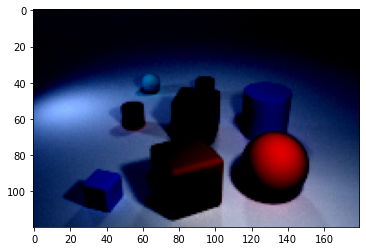

In [5]:
import matplotlib.pyplot as plt
plt.imshow(ab["source_img_data"].permute(1,2,0))

# Read and load image from index

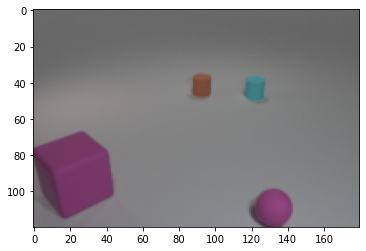

In [6]:
idx = 3
idx_fill = str(idx).zfill(6)
img = cv2.imread(f"../data/CSSDataset/images/css_test_{idx_fill}.png") 
plt.imshow(img)

In [7]:
imgs = []

In [8]:
test_queries = testset.get_test_queries()
train_queries = trainset.get_test_queries()
all_imgs = []
all_captions = []
all_queries = []
all_target_captions = []
queries_dict = {"train": trainset, "test": testset}
chosen_set_str = "train" # test or train
chosen_set = queries_dict[chosen_set_str]
num_img_to_get = 3 

if test_queries:
    # compute test query features
    imgs = []
    mods = []
    for t in tqdm(test_queries):
        imgs += [testset.get_img(t["source_img_id"])]
        mods += [t["mod"]["str"]]
        if len(imgs) >= opt.batch_size or t is test_queries[-1]:
            if "torch" not in str(type(imgs[0])):
                imgs = [torch.from_numpy(d).float() for d in imgs]
            imgs = torch.stack(imgs).float()
            imgs = torch.autograd.Variable(imgs).cuda()
            mods = [t for t in mods]
            f = model.compose_img_text(imgs, mods).data.cpu().numpy()
            all_queries += [f]
            imgs = []
            mods = []
            

100%|██████████| 18057/18057 [00:53<00:00, 340.48it/s]


- imgs là tensor `[batch_size, 3,120,180]`
- texts là list str len `batch_size`

In [9]:
imgs

[]

# Reconstruction
To perform reconstruction, one needs:
- Image + text
- Its representation in TIRG


In [12]:
sample = trainset.generate_random_query_target()
sample

{'source_img_id': 541,
 'source_img_data': tensor([[[-0.3027, -0.3027, -0.3027,  ..., -0.3198, -0.3541, -0.3541],
          [-0.3027, -0.3027, -0.3198,  ..., -0.3712, -0.3541, -0.3541],
          [-0.3198, -0.3198, -0.3198,  ..., -0.3712, -0.3541, -0.3712],
          ...,
          [-0.0287, -0.0287, -0.0287,  ...,  0.3652,  0.3652,  0.3481],
          [-0.0287, -0.0287, -0.0287,  ...,  0.3652,  0.3823,  0.3652],
          [-0.0287, -0.0287, -0.0287,  ...,  0.3823,  0.3823,  0.3481]],
 
         [[-0.1800, -0.1800, -0.1975,  ..., -0.1975, -0.2325, -0.2325],
          [-0.1800, -0.1975, -0.1975,  ..., -0.2500, -0.2325, -0.2325],
          [-0.1975, -0.1975, -0.1975,  ..., -0.2500, -0.2325, -0.2500],
          ...,
          [ 0.0826,  0.0826,  0.0651,  ...,  0.4503,  0.4678,  0.4503],
          [ 0.0651,  0.0826,  0.0826,  ...,  0.4678,  0.4678,  0.4678],
          [ 0.0826,  0.0826,  0.0826,  ...,  0.4678,  0.4678,  0.4503]],
 
         [[ 0.0256,  0.0256,  0.0256,  ...,  0.0082, -0.00

In [34]:
imgs = torch.unsqueeze(sample['source_img_data'],0).cuda()
texts = sample['mod']['str']
model.compose_img_text(imgs, [texts])

ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 1024])